In [45]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+
import re
import math
from pyspark.sql.window import Window
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor,DecisionTreeRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import MinMaxScaler
import pandas as pd
spark = SparkSession.builder.appName('example code').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext
spark.conf.set('spark.sql.session.timeZone', 'UTC')
bitcoin_schema = types.StructType([
    types.StructField('Date', types.StringType()),
    types.StructField('Symbol', types.StringType()),
    types.StructField('Open', types.FloatType()),
    types.StructField('High', types.FloatType()),
    types.StructField('Low', types.FloatType()),
    types.StructField('Close', types.FloatType()),
    types.StructField('Volume BTC', types.FloatType()),
    types.StructField('Volume USD', types.FloatType()),
])

In [46]:
col_order = ["timestamp", "Open", "High", "Low", "Close", "Volume BTC", "Volume USD", "Weighted"]
features = ["Open", "High", "Low", "Close", "Weighted"]
#col_order = ["timestamp", "Close"]
w =Window.partitionBy().orderBy(functions.col("timestamp").cast('long'))
lag =2
diff_lst = [i for i in range(1, lag+1)]

In [47]:
data = spark.read.csv("bitcoin-usd-history.csv", schema=bitcoin_schema).na.drop().cache()
data = data.withColumn("timestamp", functions.unix_timestamp("Date", 'yyyy-MM-dd hh-aa').cast("timestamp")).drop('Date')
data = data.withColumn("Weighted", data["Volume USD"] / (data["Volume BTC"] + sys.float_info.min))
data = data.select(col_order).sort("timestamp").cache()
data.show()

+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|          timestamp|   Open|   High|    Low|  Close|Volume BTC|Volume USD|          Weighted|
+-------------------+-------+-------+-------+-------+----------+----------+------------------+
|2017-07-01 11:00:00| 2562.3|2580.99| 2554.0| 2568.0|      3.04|   7781.15| 2559.588815784314|
|2017-07-01 12:00:00| 2568.0|2577.79|2555.01|2576.58|      11.0|  28231.42|2566.4927201704545|
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|     14.23|  36482.36|2563.7639176808143|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01|     18.34|  47008.07| 2563.144488625692|
|2017-07-01 15:00:00|2556.01| 2570.0| 2555.0| 2564.2|     18.34|  46953.85|2560.1881773089576|
|2017-07-01 16:00:00| 2564.2|2568.99| 2555.0| 2565.0|      8.93|  22907.08|2565.1824518805647|
|2017-07-01 17:00:00| 2565.0| 2565.0| 2549.6| 2550.0|     24.88|  63592.23|2555.9579024837312|
|2017-07-01 18:00:00| 2550.0| 2560.0|2537.07|2537.

In [48]:
feature_df = data.select(col_order).drop("Volume BTC").drop("Volume USD")
feature_df.show()

+-------------------+-------+-------+-------+-------+------------------+
|          timestamp|   Open|   High|    Low|  Close|          Weighted|
+-------------------+-------+-------+-------+-------+------------------+
|2017-07-01 11:00:00| 2562.3|2580.99| 2554.0| 2568.0| 2559.588815784314|
|2017-07-01 12:00:00| 2568.0|2577.79|2555.01|2576.58|2566.4927201704545|
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|2563.7639176808143|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01| 2563.144488625692|
|2017-07-01 15:00:00|2556.01| 2570.0| 2555.0| 2564.2|2560.1881773089576|
|2017-07-01 16:00:00| 2564.2|2568.99| 2555.0| 2565.0|2565.1824518805647|
|2017-07-01 17:00:00| 2565.0| 2565.0| 2549.6| 2550.0|2555.9579024837312|
|2017-07-01 18:00:00| 2550.0| 2560.0|2537.07|2537.07| 2553.937147722785|
|2017-07-01 19:00:00|2537.07|2559.63|2531.78| 2546.0|  2540.06349941465|
|2017-07-01 20:00:00| 2546.0|2559.69| 2530.0| 2531.0|2542.4218364260464|
|2017-07-01 21:00:00| 2531.0|2541.88| 2502.0|2529.9

In [49]:
for feature in features:
    for diff in diff_lst:
        name = feature + "_lag_{}".format(diff+1)
        feature_df = feature_df.withColumn(name, functions.lag(feature_df[feature], count=diff).over(w))

feature_df = feature_df.na.drop()
feature_df.show(2)

+-------------------+-------+-------+-------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+
|          timestamp|   Open|   High|    Low|  Close|          Weighted|Open_lag_2|Open_lag_3|High_lag_2|High_lag_3|Low_lag_2|Low_lag_3|Close_lag_2|Close_lag_3|    Weighted_lag_2|    Weighted_lag_3|
+-------------------+-------+-------+-------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|2563.7639176808143|    2568.0|    2562.3|   2577.79|   2580.99|  2555.01|   2554.0|    2576.58|     2568.0|2566.4927201704545| 2559.588815784314|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01| 2563.144488625692|   2576.58|    2568.0|   2576.58|   2577.79|  2555.01|  2555.01|    2555.08|    2576.58|2563.7639176808143|2566.4927201704545|
+----

In [50]:
# Since Next Close presents the close price in the next hour, the current open, high, low, close
# and weighted are actually the first lag value.

feature_df = feature_df.withColumn("Next Close", functions.lag(data["Close"], count=-1).over(w))
feature_df = feature_df.na.drop()
feature_df.show(2)

+-------------------+-------+-------+-------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+----------+
|          timestamp|   Open|   High|    Low|  Close|          Weighted|Open_lag_2|Open_lag_3|High_lag_2|High_lag_3|Low_lag_2|Low_lag_3|Close_lag_2|Close_lag_3|    Weighted_lag_2|    Weighted_lag_3|Next Close|
+-------------------+-------+-------+-------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+----------+
|2017-07-01 13:00:00|2576.58|2576.58|2555.01|2555.08|2563.7639176808143|    2568.0|    2562.3|   2577.79|   2580.99|  2555.01|   2554.0|    2576.58|     2568.0|2566.4927201704545| 2559.588815784314|   2556.01|
|2017-07-01 14:00:00|2555.08| 2570.0| 2555.0|2556.01| 2563.144488625692|   2576.58|    2568.0|   2576.58|   2577.79|  2555.01|  2555.01|    2555.08|    2576.58|

In [52]:
featureCols = []
for feature in features:
    featureCols.append(feature)
    for diff in diff_lst:
        featureCols.append(feature + "_lag_{}".format(diff+1))
featureCols

['Open',
 'Open_lag_2',
 'Open_lag_3',
 'High',
 'High_lag_2',
 'High_lag_3',
 'Low',
 'Low_lag_2',
 'Low_lag_3',
 'Close',
 'Close_lag_2',
 'Close_lag_3',
 'Weighted',
 'Weighted_lag_2',
 'Weighted_lag_3']

In [53]:
assembler = VectorAssembler(
        inputCols=featureCols,
        outputCol='features'

)

regressor = RandomForestRegressor(
    featuresCol='features',
    labelCol='Next Close',
    featureSubsetStrategy="auto", 
    impurity= "variance",
    numTrees=20,
    maxDepth=7,
    maxBins=32,
    seed=13579
    
)

In [54]:
train, validation = feature_df.randomSplit([0.75, 0.25])
train = train.cache()
validation = validation.cache()
train.show(2)

+-------------------+-------+------+------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+----------+
|          timestamp|   Open|  High|   Low|  Close|          Weighted|Open_lag_2|Open_lag_3|High_lag_2|High_lag_3|Low_lag_2|Low_lag_3|Close_lag_2|Close_lag_3|    Weighted_lag_2|    Weighted_lag_3|Next Close|
+-------------------+-------+------+------+-------+------------------+----------+----------+----------+----------+---------+---------+-----------+-----------+------------------+------------------+----------+
|2017-07-01 14:00:00|2555.08|2570.0|2555.0|2556.01| 2563.144488625692|   2576.58|    2568.0|   2576.58|   2577.79|  2555.01|  2555.01|    2555.08|    2576.58|2563.7639176808143|2566.4927201704545|    2564.2|
|2017-07-01 15:00:00|2556.01|2570.0|2555.0| 2564.2|2560.1881773089576|   2555.08|   2576.58|    2570.0|   2576.58|   2555.0|  2555.01|    2556.01|    2555.08| 2563.1444

In [55]:
pipeline = Pipeline(stages=[assembler, regressor])
model = pipeline.fit(train)

In [56]:
predictions = model.transform(validation)
pred_df = predictions.select("Next Close", "prediction")
pred_df.show(3)

+----------+----------------+
|Next Close|      prediction|
+----------+----------------+
|   2556.01|2477.85413488359|
|   2529.93|2477.85413488359|
|   2505.03|2477.85413488359|
+----------+----------------+
only showing top 3 rows



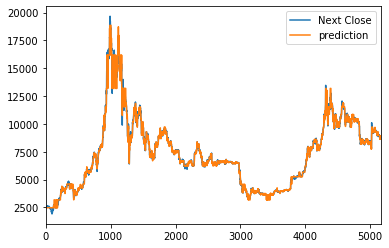

In [57]:
pred_pdf= pred_df.toPandas()
pred_pdf.plot(y=["Next Close", "prediction"])

In [58]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
score = evaluator.evaluate(predictions)

print('R square error is: %g' % (score))

R square error is: 0.996161


In [59]:
model.write().overwrite().save("bitcoin_model_OHLCW")